In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.coordinates as coord
import astropy.units as u
import gala.coordinates as gc
import h5py

import healpy as hp
import scipy.stats

%matplotlib inline

In [2]:
plt.style.use('notebook')

In [3]:
wangle = 180*u.deg

## Highlight locations

In [4]:
c_orion = coord.SkyCoord('05 35 17.3 -05 23 28', unit=(u.hourangle, u.deg), frame='icrs')
c_m13 = coord.SkyCoord('16 41 41.634 +36 27 40.75', unit=(u.hourangle, u.deg), frame='icrs')
c_sgr = coord.SkyCoord('18 55 03.1 -30 28 42', unit=(u.hourangle, u.deg), frame='icrs')

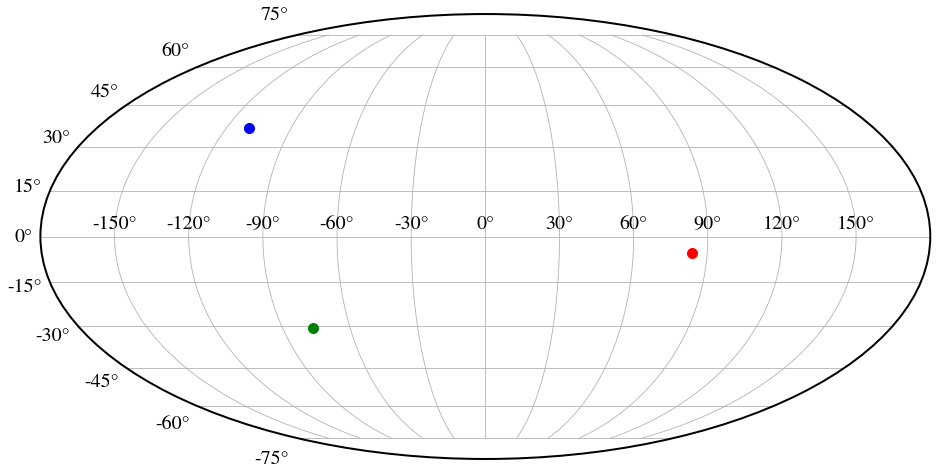

In [5]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='mollweide')

plt.plot(c_orion.ra.wrap_at(wangle).to(u.rad).value, c_orion.dec.to(u.rad).value, 'ro', ms=10)
plt.plot(c_m13.ra.wrap_at(wangle).to(u.rad).value, c_m13.dec.to(u.rad).value, 'bo', ms=10)
plt.plot(c_sgr.ra.wrap_at(wangle).to(u.rad).value, c_sgr.dec.to(u.rad).value, 'go', ms=10)

plt.grid()
plt.tight_layout()

## Velocity map

In [6]:
f = h5py.File('../data/h3_mcat_v03.0.h5','r')

In [7]:
ind = np.isfinite(f['brutus_mist_dist']) & (np.array(f['brutus_mist_logg'])<3.5)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [8]:
c = coord.SkyCoord(ra=f['gaia.ra'][ind]*u.deg, dec=f['gaia.dec'][ind]*u.deg,
                   pm_ra_cosdec=f['gaia.pmra'][ind]*u.mas/u.yr, pm_dec=f['gaia.pmdec'][ind]*u.mas/u.yr,
                   radial_velocity=0*f['brutus_mist_dist'][ind]*u.km/u.s, distance=f['brutus_mist_dist'][ind]*u.kpc)
cg = c.transform_to(gc.GD1)

gd1_c_dist = gc.GD1(phi1=cg.phi1, phi2=cg.phi2,
                    distance=cg.distance,
                    pm_phi1_cosphi2=cg.pm_phi1_cosphi2,
                    pm_phi2=cg.pm_phi2,
                    radial_velocity=cg.radial_velocity)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = gd1_c_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
# gd1_c_nosunv = coord.Galactic(rep).transform_to(gc.GD1)
cg = coord.Galactic(rep).transform_to(gc.GD1)

In [9]:
ce = cg.transform_to(coord.ICRS)

In [10]:
def gen_fast_map(ip_, nside=512):
    npixel  = hp.nside2npix(nside)
    map_ = np.bincount(ip_,minlength=npixel)
    return map_

def gen_binned_map(x, values, nside=512, statistic='mean'):
    npixel  = hp.nside2npix(nside)
    map_, be, bn = scipy.stats.binned_statistic(x, values, statistic=statistic, bins=np.arange(0,npixel+1,1))
    return map_

In [11]:
nside = 32
pix_id = hp.ang2pix(nside, ce.ra.deg, ce.dec.deg, lonlat=True)
pix_count = gen_fast_map(pix_id, nside=nside)

pix_ra = gen_binned_map(pix_id, ce.ra.to(u.deg).value, nside=nside)
pix_dec = gen_binned_map(pix_id, ce.dec.to(u.deg).value, nside=nside)
pix_pmra = gen_binned_map(pix_id, ce.pm_ra_cosdec.to(u.mas/u.yr).value, nside=nside)
pix_pmdec = gen_binned_map(pix_id, ce.pm_dec.to(u.mas/u.yr).value, nside=nside)
pix_dist = gen_binned_map(pix_id, ce.distance.to(u.kpc).value, nside=nside)

pix_pm = np.sqrt(pix_pmra**2 + pix_pmdec**2)
pix_theta_ra = pix_pmra / pix_pm
pix_theta_dec = pix_pmdec / pix_pm

In [27]:
wtarget = 33714.600
w200 = 2838
dpi200 = 200
dpitarget = dpi200 * wtarget/w200

In [28]:
dpitarget

2375.940803382664

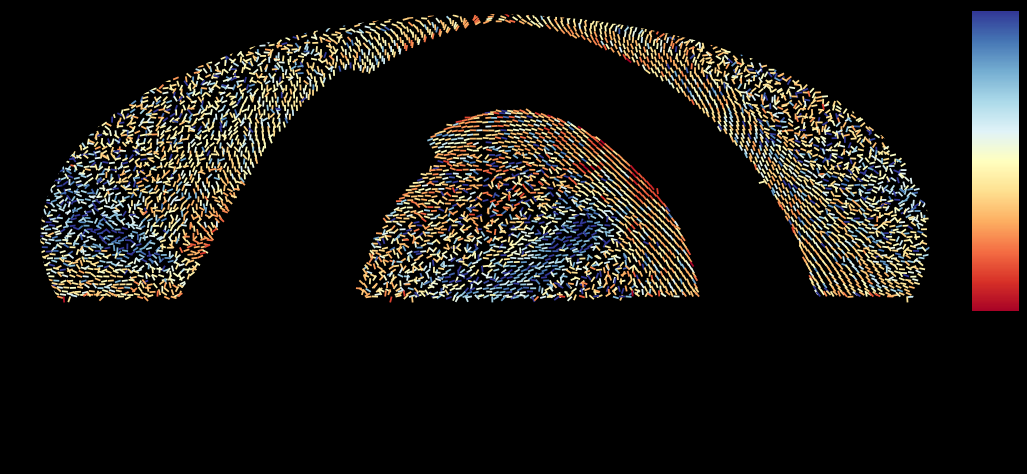

In [30]:
mpl.rcParams['figure.facecolor'] = 'k'
mpl.rcParams['savefig.facecolor'] = 'k'

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='mollweide')

parrows = plt.quiver(coord.Angle(pix_ra*u.deg).wrap_at(wangle).rad, coord.Angle(pix_dec*u.deg).rad,
                     pix_theta_ra, pix_theta_dec, pix_dist, cmap='RdYlBu',
                     headwidth=1, headlength=0, width=0.002, scale_units='inches', scale=12)
parrows.set_clim(vmin=7, vmax=20)

plt.axis('off')

# add custom colorbar
sm = plt.cm.ScalarMappable(cmap=mpl.cm.RdYlBu, norm=plt.Normalize(vmin=7, vmax=20))
sm._A = []
cax = plt.axes([0.95,0.35,0.045,0.6])
cb = fig.colorbar(sm, cax=cax, pad=0, aspect=7, ticks=[])

plt.tight_layout()
plt.savefig('../plots/poster_halo_pm_pixsky_{:03d}.svg'.format(nside))
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'

/usr/lib64/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/lib64/python3.6/site-packages/matplotlib/projections/geo.py:384: RuntimeWarning: invalid value encountered in less
  ihigh = clat < 0.087 # within 5 degrees of the poles
/usr/lib64/python3.6/site-packages/matplotlib/projections/geo.py:378: RuntimeWarning: invalid value encountered in greater
  return delta, np.abs(delta) > 0.001


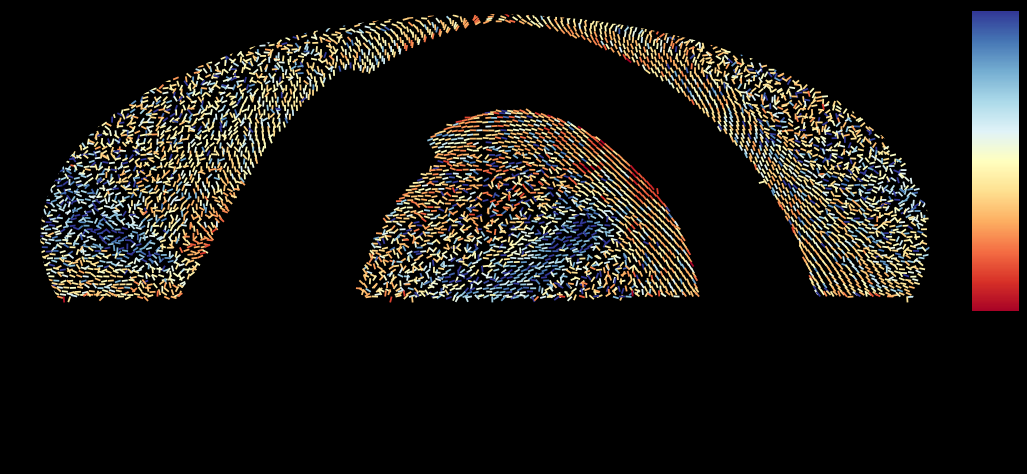

In [12]:
mpl.rcParams['figure.facecolor'] = 'k'
mpl.rcParams['savefig.facecolor'] = 'k'

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='mollweide')

parrows = plt.quiver(coord.Angle(pix_ra*u.deg).wrap_at(wangle).rad, coord.Angle(pix_dec*u.deg).rad,
                     pix_theta_ra, pix_theta_dec, pix_dist, cmap='RdYlBu',
          rasterized=True, headwidth=1, headlength=0, width=0.002, scale_units='inches', scale=12)
parrows.set_clim(vmin=7, vmax=20)

plt.axis('off')

# add custom colorbar
sm = plt.cm.ScalarMappable(cmap=mpl.cm.RdYlBu, norm=plt.Normalize(vmin=7, vmax=20))
sm._A = []
cax = plt.axes([0.95,0.35,0.045,0.6])
cb = fig.colorbar(sm, cax=cax, pad=0, aspect=7, ticks=[])

plt.tight_layout()
# plt.savefig('../plots/poster_halo_pm_pixsky_{:03d}.png'.format(nside), dpi=200)
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'

In [13]:
(220*u.km/u.s).to(u.imperial.mile/u.hr)

<Quantity 492125.98425197 mi / h>

## Sgr model

In [14]:
from astropy.table import Table

In [23]:
tsgr = Table.read('/home/ana/projects/h3/data/SgrTriax_DYN.dat.gz', format='ascii')
tsgr = tsgr[::100]
c_sgr = coord.ICRS(ra=tsgr['ra']*u.deg, dec=tsgr['dec']*u.deg, distance=tsgr['dist']*u.kpc,
                   pm_ra_cosdec=tsgr['mua']*u.mas/u.yr, pm_dec=tsgr['mud']*u.mas/u.yr)
vr = gc.vgsr_to_vhel(c_sgr, tsgr['vgsr']*u.km/u.s)
c_sgr = coord.ICRS(ra=tsgr['ra']*u.deg, dec=tsgr['dec']*u.deg, distance=tsgr['dist']*u.kpc,
                   pm_ra_cosdec=tsgr['mua']*u.mas/u.yr, pm_dec=tsgr['mud']*u.mas/u.yr, radial_velocity=vr)
sgr_gal = c_sgr.transform_to(coord.Galactocentric)

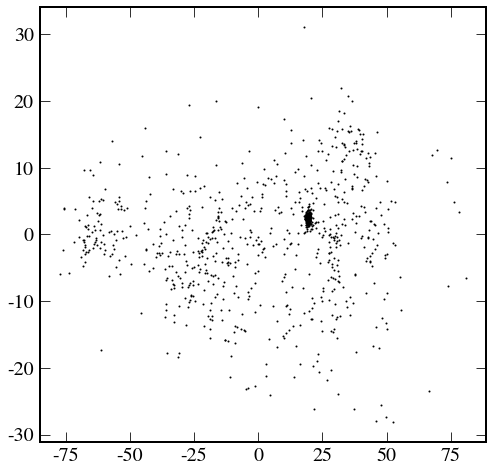

In [24]:
plt.plot(sgr_gal.x, sgr_gal.y, 'ko', ms=1)

(-20, 20)

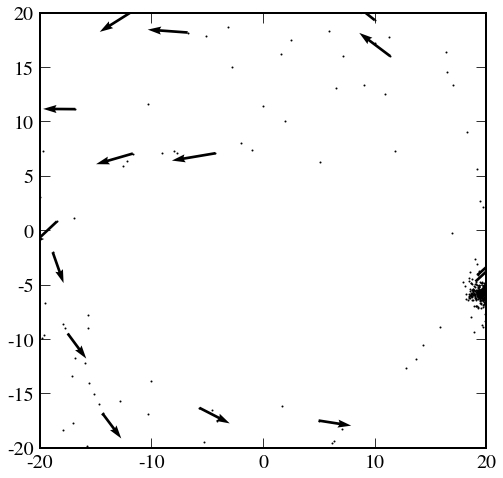

In [26]:
plt.plot(sgr_gal.x, sgr_gal.z, 'ko', ms=1)
plt.quiver(sgr_gal.x[::10], sgr_gal.z[::10], sgr_gal.v_x[::10], sgr_gal.v_z[::10])

plt.xlim(-20,20)
plt.ylim(-20,20)